In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn as sk
import scipy.stats as sc
import numpy as np
import statsmodels.api as stm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

In [29]:
df = pd.read_csv("Auto.data", delim_whitespace=True, na_values='?') #\s+ one or more space as delimiter (regex in python) or sep = "\t"
print(df.head(2))
print(df.columns)

    mpg  cylinders  displacement  horsepower  weight  acceleration  year  \
0  18.0          8         307.0       130.0  3504.0          12.0    70   
1  15.0          8         350.0       165.0  3693.0          11.5    70   

   origin                       name  
0       1  chevrolet chevelle malibu  
1       1          buick skylark 320  
Index(['mpg', 'cylinders', 'displacement', 'horsepower', 'weight',
       'acceleration', 'year', 'origin', 'name'],
      dtype='object')


C:\Users\Alim\AppData\Local\Temp\ipykernel_2108\875242272.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv("Auto.data", delim_whitespace=True, na_values='?') #\s+ one or more space as delimiter (regex in python) or sep = "\t"


In [30]:
model = sk.linear_model.LinearRegression() #mpg from horsepower
df_noname = df.drop(columns="name")
cor = df_noname.corr()
print(cor)

                   mpg  cylinders  displacement  horsepower    weight  \
mpg           1.000000  -0.776260     -0.804443   -0.778427 -0.831739   
cylinders    -0.776260   1.000000      0.950920    0.842983  0.897017   
displacement -0.804443   0.950920      1.000000    0.897257  0.933104   
horsepower   -0.778427   0.842983      0.897257    1.000000  0.864538   
weight       -0.831739   0.897017      0.933104    0.864538  1.000000   
acceleration  0.422297  -0.504061     -0.544162   -0.689196 -0.419502   
year          0.581469  -0.346717     -0.369804   -0.416361 -0.307900   
origin        0.563698  -0.564972     -0.610664   -0.455171 -0.581265   

              acceleration      year    origin  
mpg               0.422297  0.581469  0.563698  
cylinders        -0.504061 -0.346717 -0.564972  
displacement     -0.544162 -0.369804 -0.610664  
horsepower       -0.689196 -0.416361 -0.455171  
weight           -0.419502 -0.307900 -0.581265  
acceleration      1.000000  0.282901  0.210084  

In [31]:
print(df_noname["horsepower"].isna().sum()) #5 NaNs
print(df_noname["horsepower"][df_noname["horsepower"].isna()])
print(df_noname["mpg"].isna().sum())
df_clean = df[~df["horsepower"].isna()]
df = df_clean
df_noname = df.drop(columns=["name"])
X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(df_noname["horsepower"], df_noname["mpg"])
X_train = X_train.values.reshape(-1, 1)
X_test = X_test.to_frame()

5
32    NaN
126   NaN
330   NaN
336   NaN
354   NaN
Name: horsepower, dtype: float64
0


In [32]:
def calc_intervals(model, df, columns, target, *args, **kwargs): #Pass ndarray or df
    temp = df[columns]
    rss = ((target - model.predict(temp)) ** 2).sum() #Calculatiton of RSS
    sigma = np.sqrt(rss / (df.shape[0] - len(columns) - 1)) #Variance of errors

    X = np.array(df[columns])
    X = np.c_[np.ones(X.shape[0]), X]

    intervals = []
    corr_mat = np.linalg.inv(np.dot(X.T, X)) * (sigma ** 2) #Variance of coefficients
    alpha = 1 - kwargs.get("alpha", 0.95)

    if(alpha > 1 or alpha < 0):
        raise ValueError("Alpha must be in range (0;1)")

    t_value = sc.t.ppf(1 - alpha / 2, df.shape[0] - len(columns) - 1) #T-statistic
    for i in range(len(columns)):
        dif = t_value * np.sqrt( corr_mat[i + 1][i + 1] )
        intervals.append( (model.coef_[i] - dif, model.coef_[i] + dif) )
    
    intervals.append("Predictions")
    for vars in args:

        if not isinstance(vars, (np.ndarray, pd.DataFrame)):
            continue
        
        y_hat = model.predict(vars)
        vars = np.c_[np.ones(vars.shape[0]), vars] #Adding intercept

        for i in range( len(y_hat) ):
            dif = np.sqrt(1 + np.dot(np.dot(vars[i], corr_mat), vars[i].T)) * t_value
            intervals.append( (y_hat[i] - dif, y_hat[i] + dif) )
    
    return intervals

columns = ['horsepower']

model.fit(X_train, y_train)

if isinstance(X_train, np.ndarray): #Transform nparray to df
    X_train = X_train.reshape(1, -1)
    X_train = pd.DataFrame( {'horsepower' : X_train[0]} )

#model, df_train, columns, y_train, (args x_test), (kwargs alpha)
intervals = calc_intervals(model, X_train, columns, y_train, X_test) #Order of x matters! (ndarray)

for i in intervals:
    print(i)
    

(-0.17881923755390736, -0.14841469557510809)
Predictions
(13.907024023346523, 18.253631050529528)
(9.662566550752409, 14.317240194898254)
(19.74827394100078, 23.865568792390814)
(22.210953918166865, 26.31139781215996)
(21.39287291949466, 25.493309145187087)
(19.583198841160073, 23.703409959102505)
(26.74077473377783, 30.944127124161422)
(23.83867901292881, 27.956012048688162)
(27.860077812998224, 32.11546157684414)
(23.026218758372515, 27.132302637599388)
(27.540789424277445, 31.78028209930689)
(15.588860739545645, 19.84413366562056)
(13.907024023346523, 18.253631050529528)
(3.641788304581686, 8.884830781553442)
(23.351538378061598, 27.461450884168336)
(23.026218758372515, 27.132302637599388)
(17.427224060598334, 21.60534360898704)
(7.092063143913628, 11.979234604801803)
(13.56950091562393, 17.93668629199409)
(13.907024023346523, 18.253631050529528)
(2.7756596090183137, 8.114789811471729)
(26.90098482485565, 31.111150966212623)
(24.809962271546443, 28.948132388844623)
(23.8386790129288

C:\Users\Alim\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
C:\Users\Alim\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


C:\Users\Alim\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
C:\Users\Alim\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


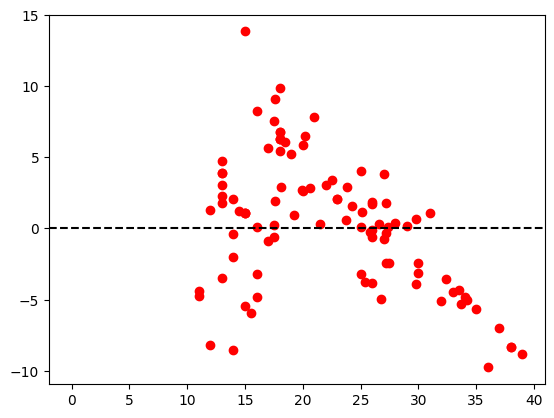

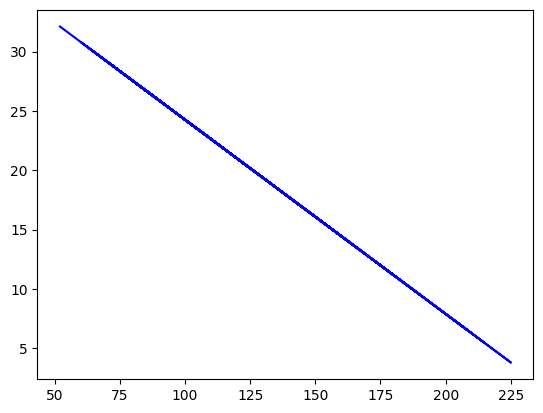

In [ ]:
def plot_residuals(model, X_test, y_test):
    fig, ax = plt.subplots()
    y_pred = model.predict(X_test)
    residuals = y_pred - y_test
    ax.scatter(y_test, residuals, color='red')
    ax.axline([1, 0], [0, 0], ls='--', color='black')

def plot_line(model, X_test, **kwargs):
    new = kwargs.get("new", False)
    if new:
        fig, ax = plt.subplots()
    predictions = model.predict(X_test)
    plt.plot(X_test, predictions, color='blue')

plot_residuals(model, X_test, y_test)
plot_line(model, X_test, new=True)
plt.show()

In [34]:
cols = df_noname.columns
cols.drop("mpg")
X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(df_noname[cols], df_noname["mpg"])

formula = "mpg ~ " + " + ".join(df_noname.columns.drop("mpg"))
model_formula = ols(formula, data=X_train).fit()
anova_table = anova_lm(model_formula)
print(anova_table)

                 df        sum_sq       mean_sq           F        PR(>F)
cylinders       1.0  10698.529307  10698.529307  917.149567  3.209855e-91
displacement    1.0    902.094429    902.094429   77.333575  1.382256e-16
horsepower      1.0    459.658496    459.658496   39.405004  1.273971e-09
weight          1.0    743.568974    743.568974   63.743711  3.472293e-14
acceleration    1.0      0.285155      0.285155    0.024445  8.758674e-01
year            1.0   1813.791829   1813.791829  155.490380  8.587365e-29
origin          1.0    309.446842    309.446842   26.527855  4.844581e-07
Residual      286.0   3336.183642     11.664978         NaN           NaN


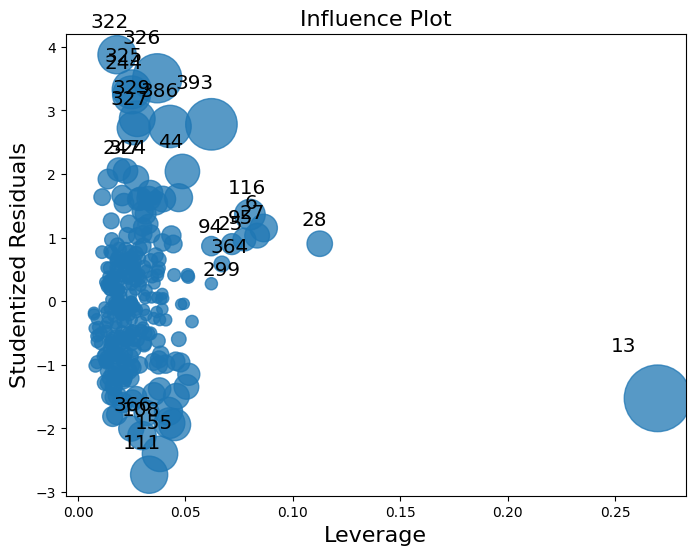

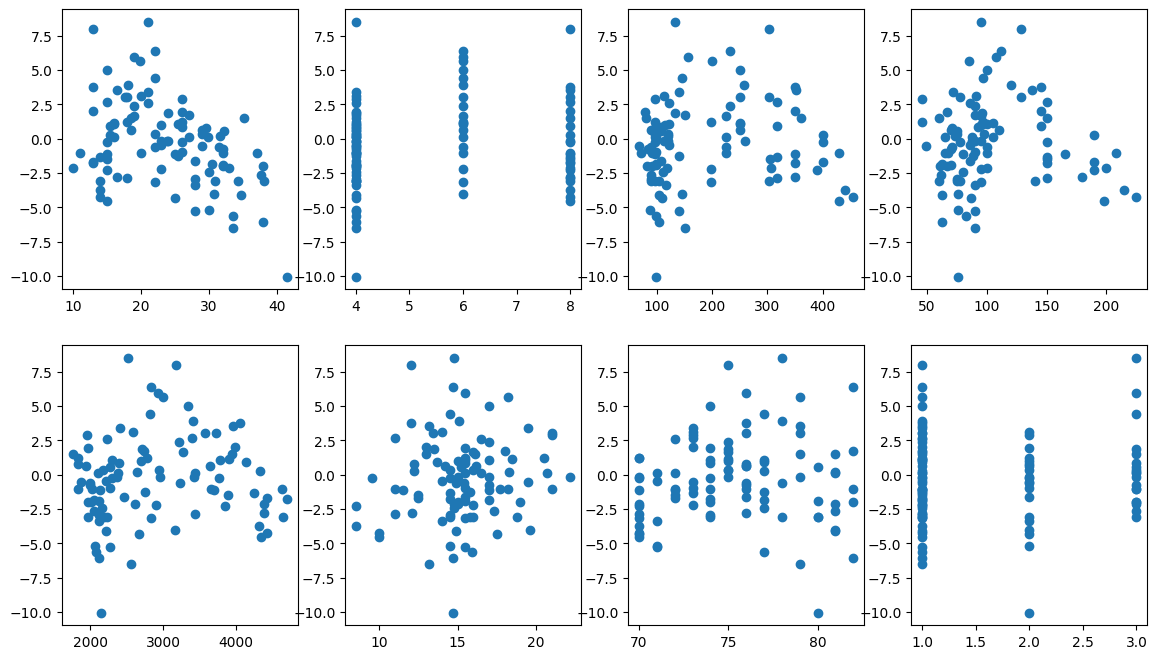

In [35]:
fig, ax = plt.subplots(figsize=(8, 6))
fig = stm.graphics.influence_plot(model_formula, ax=ax, criterion="cooks")

fig, ax = plt.subplots(2, 4, figsize=(14, 8))
for i in range( len(cols) ):
    ax[i // 4, i % 4].scatter( X_test[cols[i]], (model_formula.predict(X_test) - y_test), marker='o', label = cols[i] )

In [36]:
df_syn = df_noname.copy(deep=True)

for i in range(10):
    x = np.random.randint(0, len(df_noname.columns) - 1)
    y = np.random.randint(0, len(df_noname.columns) - 1)
    while(y == x):
        y = np.random.randint(0, len(df_noname.columns) - 1)

    values = df_noname[df_noname.columns[x]] * df_noname[df_noname.columns[y]]
    buf = pd.DataFrame( {df_noname.columns[x] + ' : ' + df_noname.columns[y] : values}  )
    df_syn = pd.concat([df_syn, buf], axis=1)
df_syn.head(4)

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,mpg : weight,mpg : year,year : displacement,displacement : year,acceleration : horsepower,year : mpg,weight : acceleration,displacement : mpg,year : weight,horsepower : acceleration
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,63072.0,1260.0,21490.0,21490.0,1560.0,1260.0,42048.0,5526.0,245280.0,1560.0
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,55395.0,1050.0,24500.0,24500.0,1897.5,1050.0,42469.5,5250.0,258510.0,1897.5
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,61848.0,1260.0,22260.0,22260.0,1650.0,1260.0,37796.0,5724.0,240520.0,1650.0
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,54928.0,1120.0,21280.0,21280.0,1800.0,1120.0,41196.0,4864.0,240310.0,1800.0


In [37]:
cols = df_syn.columns
cols.drop("mpg")

formula = "mpg ~ " + " + ".join(cols)
X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(df_syn[cols], df_noname["mpg"])

formula = "mpg ~ " + " + ".join(df_syn.columns.drop("mpg"))
model_formula = ols(formula, data=X_train).fit()
anova_table = anova_lm(model_formula)
print(anova_table)

                            df        sum_sq       mean_sq              F  \
cylinders                  1.0  10850.762117  10850.762117  434537.443927   
displacement               1.0    902.613712    902.613712   36146.719553   
horsepower                 1.0    402.723965    402.723965   16127.774314   
weight                     1.0    651.177449    651.177449   26077.521685   
acceleration               1.0      0.327520      0.327520      13.116116   
year                       1.0   1986.513001   1986.513001   79553.332055   
origin                     1.0    268.520802    268.520802   10753.377663   
mpg:weight                 1.0   2457.144614   2457.144614   98400.585002   
mpg:year                   1.0    910.919444    910.919444   36479.336878   
year:displacement          1.0      9.591574      9.591574     384.111087   
acceleration:horsepower    1.0      0.371430      0.371430      14.874563   
weight:acceleration        1.0      0.026389      0.026389       1.056790   

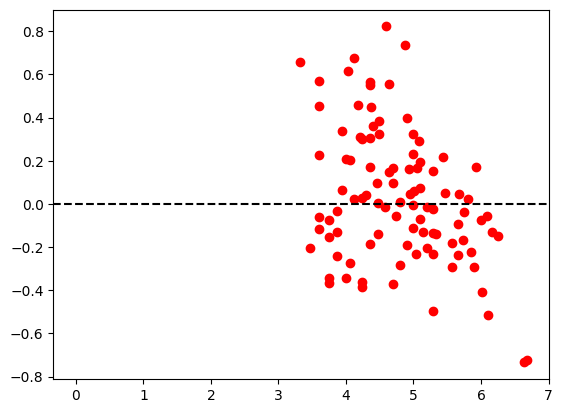

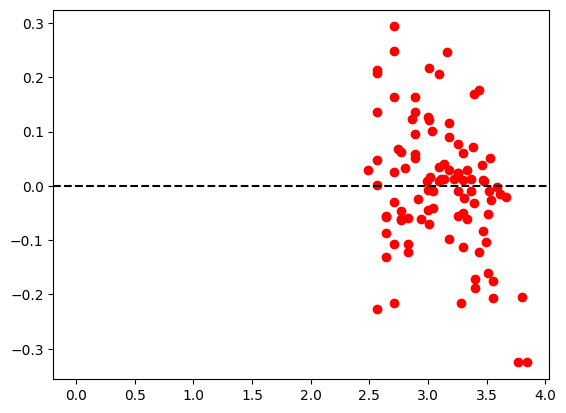

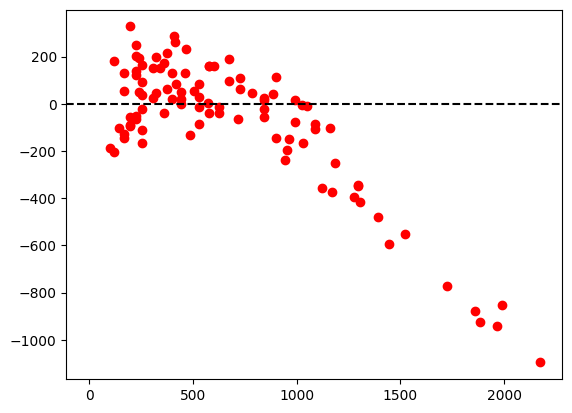

In [ ]:
def transformation(df, cols, op):
    buf = df.copy(deep=True)
    buf[cols] = op(buf[cols])
    return buf

def try_transform(op):
    df_tr = transformation(df_noname, ['mpg'], op)

    model = sk.linear_model.LinearRegression()

    X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(df_tr[
        df_tr.columns.drop("mpg")], df_tr["mpg"])

    model.fit(X_train, y_train)

    plot_residuals(model, X_test, y_test)

root = lambda x : np.sqrt(x) #fan shape
try_transform(root)
log = lambda x: np.log(x) #fan shape
try_transform(log)
power = lambda x : x ** 2 #curve
try_transform(power)